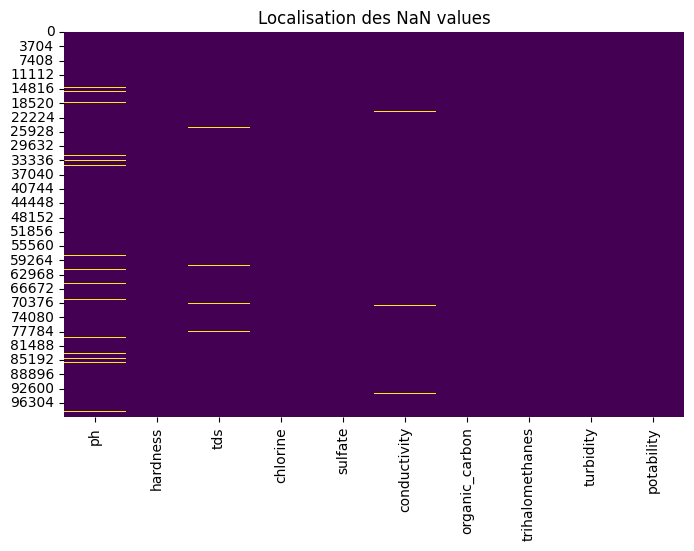

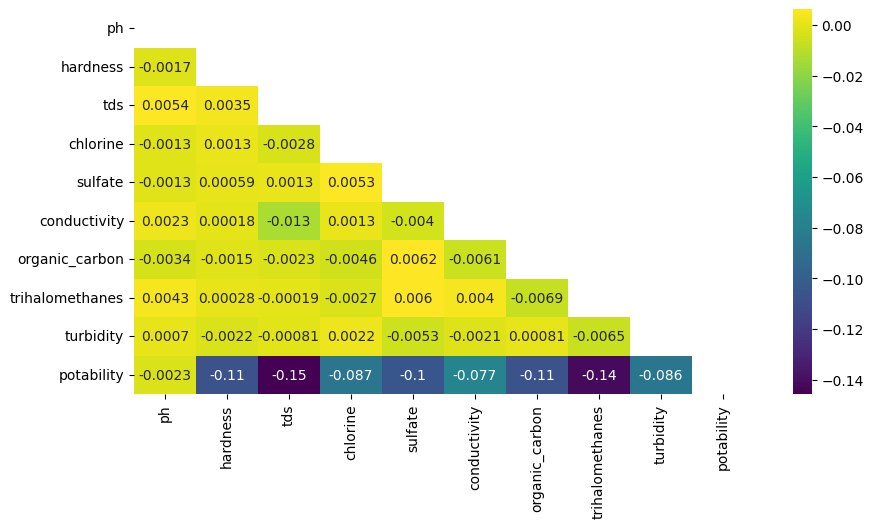

In [3]:
import platform
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn import datasets, decomposition, metrics, preprocessing, utils
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from tqdm.notebook import tqdm


############# Préprocessing #############

#Lecture du fichier
data = pd.read_csv('Data/Watera.csv')


#Visualisation des localisations des NaN values
plt.figure(figsize=(8, 5))
ax = sns.heatmap(data.isna(), cbar=False, cmap="viridis")
plt.title("Localisation des NaN values")

#On retire les NaN values
data.dropna(axis="index", inplace=True)
data.reset_index(drop=True, inplace=True)


#Vérification des corrélations entre les features 
plt.figure(figsize=(10, 5))
mask = np.triu(np.ones_like(data.corr(numeric_only=True), dtype=bool))
ax = sns.heatmap(
    data.corr(numeric_only=True),
    cbar=True,
    annot=True,
    cmap="viridis",
    mask=mask,
)  #On a des données peu corélées, super pour l'apprentissage !

